<a href="https://colab.research.google.com/github/HussainSirtaj/Facemask-Recognition/blob/main/final_facemask_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Make sure pip is up-to-date and install required libs
!pip install -q --upgrade pip
!pip install -q tensorflow opencv-python-headless lxml matplotlib scikit-learn

In [ ]:
!unzip -q archive.zip -d archive


In [ ]:
!ls -la archive
!echo "=== with_mask samples ==="
!ls archive/data/with_mask | head -n 10
!echo "=== without_mask samples ==="
!ls archive/data/without_mask | head -n 10


total 12
drwxr-xr-x 3 root root 4096 Nov 22 06:16 .
drwxr-xr-x 1 root root 4096 Nov 22 06:16 ..
drwxr-xr-x 4 root root 4096 Nov 22 06:16 data
=== with_mask samples ===
with_mask_1000.jpg
with_mask_1001.jpg
with_mask_1002.jpg
with_mask_1003.jpg
with_mask_1004.jpg
with_mask_1005.jpg
with_mask_1006.jpg
with_mask_1007.jpg
with_mask_1008.jpg
with_mask_1009.jpg
=== without_mask samples ===
without_mask_1000.jpg
without_mask_1001.jpg
without_mask_1002.jpg
without_mask_1003.jpg
without_mask_1004.jpg
without_mask_1005.jpg
without_mask_1006.jpg
without_mask_1007.jpg
without_mask_1008.jpg
without_mask_1009.jpg


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Paths
DATASET_DIR = "archive"
WITH_MASK_DIR = os.path.join(DATASET_DIR, "with_mask")
WITHOUT_MASK_DIR = os.path.join(DATASET_DIR, "without_mask")

# Image size (you can change to 150 or 128 if preferred)
IMG_SIZE = 128


In [ ]:
images = []
labels = []

# Label mapping
label_map = {
    "without_mask": 0,
    "with_mask": 1
}

def load_images_from_folder(folder, label):
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)

        # Load image
        img = cv2.imread(img_path)
        if img is None:
            continue  # skip unreadable files

        # Resize
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # Convert BGR → RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Normalize
        img = img.astype("float32") / 255.0

        images.append(img)
        labels.append(label)

# Corrected paths for loading images
CORRECT_WITH_MASK_DIR = os.path.join(DATASET_DIR, "data", "with_mask")
CORRECT_WITHOUT_MASK_DIR = os.path.join(DATASET_DIR, "data", "without_mask")

# Load both folders using corrected paths
load_images_from_folder(CORRECT_WITH_MASK_DIR, label_map["with_mask"])
load_images_from_folder(CORRECT_WITHOUT_MASK_DIR, label_map["without_mask"])

images = np.array(images)
labels = np.array(labels)

print("Total images:", images.shape)
print("Total labels:", labels.shape)


Total images: (7553, 128, 128, 3)
Total labels: (7553,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)


Training set: (6042, 128, 128, 3) (6042,)
Testing set: (1511, 128, 128, 3) (1511,)


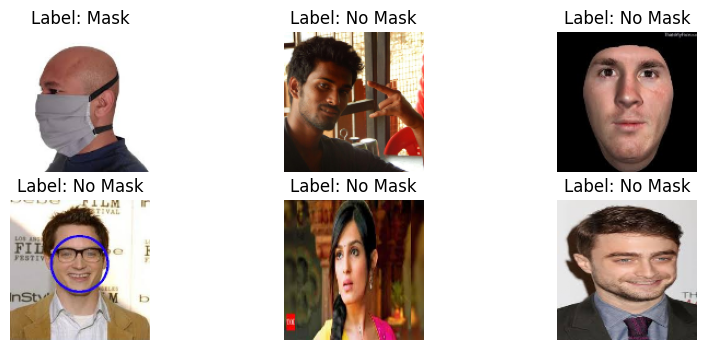

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X_train[i])
    plt.title("Label: " + ("Mask" if y_train[i] == 1 else "No Mask"))
    plt.axis("off")

plt.show()


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')   # Output: 0 or 1
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)


Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.7440 - loss: 0.5088 - val_accuracy: 0.8842 - val_loss: 0.2738
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.8877 - loss: 0.2676 - val_accuracy: 0.8900 - val_loss: 0.2683
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.9114 - loss: 0.2273 - val_accuracy: 0.9132 - val_loss: 0.2234
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9312 - loss: 0.1838 - val_accuracy: 0.9264 - val_loss: 0.1990
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.9479 - loss: 0.1521 - val_accuracy: 0.9272 - val_loss: 0.2143
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9559 - loss: 0.1125 - val_accuracy: 0.9396 - val_loss: 0.1815
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.9715 - loss: 0.0973 - val_accuracy: 0.9454 - val_loss: 0.1837
Epoch 8/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9693 - loss: 0.0830 - val_accu

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 450ms/step - accuracy: 0.9691 - loss: 0.1415
Test Accuracy: 0.9583057761192322
Test Loss: 0.16348552703857422


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 287ms/step - accuracy: 0.9691 - loss: 0.1415
Test Accuracy: 0.9583057761192322


In [ ]:
from google.colab import files
uploaded = files.upload()

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Get filename
image_path = list(uploaded.keys())[0]
print("Uploaded:", image_path)


Saving image24.png to image24.png
Uploaded: image24.png


In [ ]:
# Load image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize same as training
img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
img_norm = img_resized.astype("float32") / 255.0

# Expand dims → shape: (1, IMG_SIZE, IMG_SIZE, 3)
input_img = np.expand_dims(img_norm, axis=0)

# Prediction
pred = model.predict(input_img)[0][0]   # single value

label = "Mask" if pred >= 0.5 else "No Mask"
confidence = pred if pred >= 0.5 else (1 - pred)

print(f"Prediction: {label} ({confidence*100:.2f}% confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Prediction: Mask (100.00% confidence)


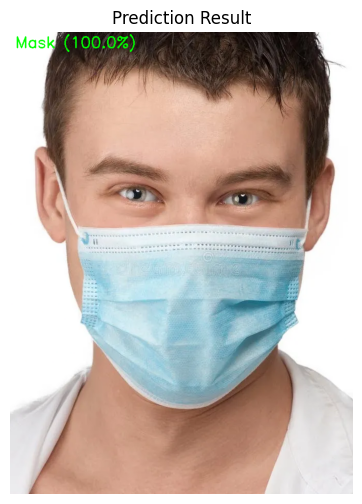

In [ ]:
# Copy image for drawing
output_img = img_rgb.copy()

# Label text
text = f"{label} ({confidence*100:.1f}%)"

# Draw text (cv2.putText wants BGR, so convert)
output_bgr = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR)
cv2.putText(
    output_bgr,
    text,
    (10, 30),                   # Position
    cv2.FONT_HERSHEY_SIMPLEX,
    1.0,                        # Font scale
    (0, 255, 0) if label=="Mask" else (0, 0, 255),  # Green/Red
    2
)

# Convert back to RGB for display
output_rgb = cv2.cvtColor(output_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(output_rgb)
plt.axis("off")
plt.title("Prediction Result")
plt.show()


Saving image1232.png to image1232.png
Uploaded: image1232.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Prediction: No Mask (99.98% confidence)


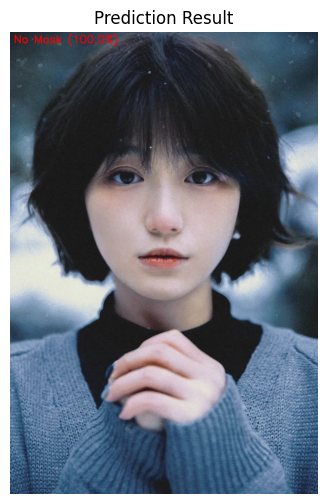

In [ ]:
from google.colab import files
uploaded = files.upload()

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Get filename
image_path = list(uploaded.keys())[0]
print("Uploaded:", image_path)
# Load image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize same as training
img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
img_norm = img_resized.astype("float32") / 255.0

# Expand dims → shape: (1, IMG_SIZE, IMG_SIZE, 3)
input_img = np.expand_dims(img_norm, axis=0)

# Prediction
pred = model.predict(input_img)[0][0]   # single value

label = "Mask" if pred >= 0.5 else "No Mask"
confidence = pred if pred >= 0.5 else (1 - pred)

print(f"Prediction: {label} ({confidence*100:.2f}% confidence)")
# Copy image for drawing
output_img = img_rgb.copy()

# Label text
text = f"{label} ({confidence*100:.1f}%)"

# Draw text (cv2.putText wants BGR, so convert)
output_bgr = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR)
cv2.putText(
    output_bgr,
    text,
    (10, 30),                   # Position
    cv2.FONT_HERSHEY_SIMPLEX,
    1.0,                        # Font scale
    (0, 255, 0) if label=="Mask" else (0, 0, 255),  # Green/Red
    2
)

# Convert back to RGB for display
output_rgb = cv2.cvtColor(output_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(output_rgb)
plt.axis("off")
plt.title("Prediction Result")
plt.show()



Saving image1.png to image1.png
Uploaded: image1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction: Mask (79.11% confidence)


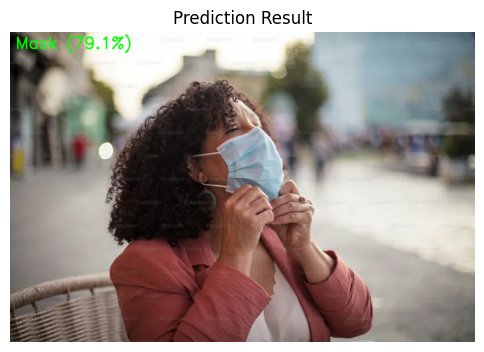

In [ ]:
from google.colab import files
uploaded = files.upload()

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Get filename
image_path = list(uploaded.keys())[0]
print("Uploaded:", image_path)
# Load image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize same as training
img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
img_norm = img_resized.astype("float32") / 255.0

# Expand dims → shape: (1, IMG_SIZE, IMG_SIZE, 3)
input_img = np.expand_dims(img_norm, axis=0)

# Prediction
pred = model.predict(input_img)[0][0]   # single value

label = "Mask" if pred >= 0.5 else "No Mask"
confidence = pred if pred >= 0.5 else (1 - pred)

print(f"Prediction: {label} ({confidence*100:.2f}% confidence)")
# Copy image for drawing
output_img = img_rgb.copy()

# Label text
text = f"{label} ({confidence*100:.1f}%)"

# Draw text (cv2.putText wants BGR, so convert)
output_bgr = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR)
cv2.putText(
    output_bgr,
    text,
    (10, 30),                   # Position
    cv2.FONT_HERSHEY_SIMPLEX,
    1.0,                        # Font scale
    (0, 255, 0) if label=="Mask" else (0, 0, 255),  # Green/Red
    2
)

# Convert back to RGB for display
output_rgb = cv2.cvtColor(output_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(output_rgb)
plt.axis("off")
plt.title("Prediction Result")
plt.show()

